In [115]:
import numpy as np
import scipy
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import networkx as nx
import community as community_louvain
import pandas
import scprep
import math
import sys
import random
import matplotlib.pyplot as plt
from ps1_functions import compute_distances, compute_affinity_matrix, diff_map_info, get_diff_map
from ps2_functions import load_json_files, sbm, L, compute_fourier_basis, gft, igft, filterbank_matrix, kmeans, kmeans_plusplus
import phate
%matplotlib inline

In [137]:
A, gt, coords = sbm(500, 8,  2 / 100, 1/5, 0.15)
sbm_dist = compute_distances(coords) 
sbm_affin = compute_affinity_matrix(sbm_dist, kernel_type='adaptive', k=5)
print(sbm_affin)

[[1.00000000e+000 2.07590939e-035 4.42311557e-165 ... 9.23028629e-144
  1.08048293e-180 3.52909355e-037]
 [2.07590939e-035 1.00000000e+000 3.08873260e-105 ... 1.20636553e-047
  1.67394615e-119 8.72621156e-064]
 [4.42311557e-165 3.08873260e-105 1.00000000e+000 ... 4.15274623e-045
  3.27156875e-003 4.76801336e-008]
 ...
 [9.23028629e-144 1.20636553e-047 4.15274623e-045 ... 1.00000000e+000
  2.85649874e-059 6.29686526e-030]
 [1.08048293e-180 1.67394615e-119 3.27156875e-003 ... 2.85649874e-059
  1.00000000e+000 8.59047317e-007]
 [3.52909355e-037 8.72621156e-064 4.76801336e-008 ... 6.29686526e-030
  8.59047317e-007 1.00000000e+000]]


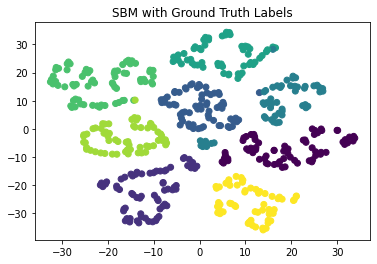

Calculating PHATE...
  Running PHATE on 500 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.09 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.21 seconds.
Calculated PHATE in 0.52 seconds.


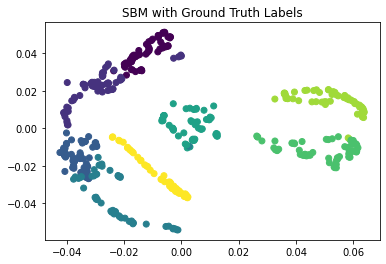

In [138]:
tsne_embedded = TSNE(n_components=2).fit_transform(sbm_affin)
plt.figure()
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=gt);
plt.title("SBM with Ground Truth Labels")
plt.show();

phate_op = phate.PHATE()
phate_embedded = phate_op.fit_transform(sbm_affin)
plt.figure()
plt.scatter(phate_embedded[:,0], phate_embedded[:,1], c=gt);
plt.title("SBM with Ground Truth Labels")
plt.show();

In [164]:
# parameters
A = sbm_affin
fire_temp = 250
flash_point = 150
heat_list = []

# initialization
n_points = A.shape[0] #the number of entries/data points
n_label_list = -np.ones(n_points) #a list of labels for each point
remaining_points = n_points
num_label = 0
first_flint = True
centroids = []

while (remaining_points > 0): #iterate until there is a label for each point
    if first_flint == True:
        flint = random.randint(0, remaining_points-1) #choose a random point to start a fire
        first_flint = False
    else:
        dist = []
        for i in range(n_points):
            if n_label_list[i] >= 0:
                dist.append(0)
            else:
                ## compute distance of 'point' from each of the previously 
                ## selected centroid and store the minimum distance 
                d = sys.maxsize
                for j in range(len(centroids)): 
                    temp_dist = np.linalg.norm(A[i, :] - centroids[j]) 
                    d = min(d, temp_dist) 
                dist.append(d)
              
        ## select data point with probability 
        ## proportional to the current flint distance as our next centroid 
        dist = np.array(dist)
        flint = np.random.choice(np.arange(len(dist)), size = 1, p = dist / sum(dist))[0]
        dist = []
        
    print("flint selected: " + str(flint))
        
    remaining_points = remaining_points - 1
    n_label_list[flint] = num_label    
    centroids.append(A[flint, :])
    burning_list = [flint]
        
    while len(burning_list) != 0:
        flint_neighbors = A[burning_list[0], :] #point on fire
        for idx, neighbor_dist in enumerate(flint_neighbors):
            if n_label_list[idx] == -1: #check if node is labeled
                threshold = flash_point / np.sum(A[idx, :]) #calculate the threshold by flashpoint / degree
                heat = np.mean(fire_temp * A[n_label_list == num_label, idx]) #calculate the heat by fire_temp * affinity
                if heat > threshold:
                    burning_list.append(burning_list[0]) #reconsider neighbors of current burning node
                    burning_list.append(idx) #consider neighbors of current node's neighbor
                    print(fire_temp, A[n_label_list == num_label, idx]) 
                    print(" burned node ", idx)
                    print(" " + str(burning_list[0]) + "-" + str(idx) + \
                        "|heat: " + str(heat) + \
                        "|threshold: " + str(threshold))
                    remaining_points = remaining_points - 1
                    heat_list.append(heat)
                    n_label_list[idx] = num_label
        burning_list = burning_list[1:]
        
    num_label = num_label + 1

flint selected: 322
250 [0.47773148]
 burned node  2
 322-2|heat: 119.43286914146847|threshold: 20.346534313232176
250 [0.27732867 0.09912592]
 burned node  21
 322-21|heat: 47.05682437523036|threshold: 21.48758688843181
250 [0.34724252 0.82181027 0.24767368]
 burned node  26
 322-26|heat: 118.06053941213388|threshold: 19.166740858951684
250 [0.13266527 0.09851046 0.27721022 0.55048273]
 burned node  41
 322-41|heat: 66.17929261968506|threshold: 23.728633962788823
250 [0.00887389 0.07722969 0.21094053 0.2372534  0.03357933]
 burned node  144
 322-144|heat: 28.393841748841396|threshold: 23.272516034577517
250 [0.00796613 0.03879101 0.13698212 0.43910314 0.75451842 0.05511161]
 burned node  189
 322-189|heat: 59.686351287165756|threshold: 24.032725977134355
250 [3.93045243e-04 1.15059513e-02 2.86738978e-02 5.75529928e-02
 4.51678552e-01 4.30350815e-01 2.36991727e-03]
 burned node  254
 322-254|heat: 35.09018470190964|threshold: 28.103135849474075
250 [0.0071895  0.07246375 0.19119289 0.2

flint selected: 188
250 [0.2884158]
 burned node  20
 188-20|heat: 72.10394956132843|threshold: 24.068450082115415
250 [0.20944828 0.05364848]
 burned node  148
 188-148|heat: 32.88709455262964|threshold: 28.361254752371952
250 [0.08534438 0.01618215 0.45367424]
 burned node  192
 188-192|heat: 46.26673105558612|threshold: 23.207646791580668
250 [0.77285464 0.11016208 0.44748866 0.2194855 ]
 burned node  228
 188-228|heat: 96.87442941842632|threshold: 23.73206492949658
250 [0.82144492 0.1931832  0.31958592 0.05598973 0.50493548]
 burned node  234
 188-234|heat: 94.75696278586754|threshold: 24.130309165971493
250 [0.73066278 0.10929229 0.6226628  0.19055414 0.86685673 0.65211297]
 burned node  243
 188-243|heat: 132.17257167081115|threshold: 23.30698625938299
250 [0.20952334 0.05272806 0.71620748 0.22521622 0.20927203 0.35321229
 0.36512385]
 burned node  269
 188-269|heat: 76.11725988024068|threshold: 25.08913203661248
250 [0.15663743 0.81427149 0.06579377 0.02706327 0.10110303 0.16363

flint selected: 342
250 [0.3885477]
 burned node  3
 342-3|heat: 97.13692429637982|threshold: 30.045918136796015
250 [0.2407151  0.52579117]
 burned node  68
 342-68|heat: 95.81328352189522|threshold: 26.17382144631101
250 [0.06244452 0.53432337 0.25021831]
 burned node  110
 342-110|heat: 70.58218342054722|threshold: 24.648192879413426
250 [0.04086587 0.4202404  0.50346291 0.09818902]
 burned node  200
 342-200|heat: 66.42238771538587|threshold: 29.713403689796248
250 [0.72701082 0.21222662 0.09803393 0.09582153 0.19933205]
 burned node  203
 342-203|heat: 66.62124732988914|threshold: 25.830828667682145
250 [0.10035333 0.23157164 0.20803946 0.45711467 0.1850618  0.10633429]
 burned node  227
 342-227|heat: 53.686466126928714|threshold: 32.63190535693807
250 [0.01288257 0.09120941 0.46690274 0.33790229 0.03926722 0.17835575
 0.05219   ]
 burned node  245
 342-245|heat: 42.096785463727535|threshold: 27.17106731053193
250 [0.13002655 0.47947204 0.46199708 0.13575119 0.1276592  0.13269024

flint selected: 71
250 [0.19427763]
 burned node  30
 71-30|heat: 48.569407396056185|threshold: 28.01017118786381
250 [0.09710389 0.36470937]
 burned node  63
 71-63|heat: 57.726658295022304|threshold: 25.384239365628545
250 [0.25335364 0.07439092 0.30376916]
 burned node  81
 71-81|heat: 52.62614292230643|threshold: 24.433705205485175
250 [0.0094239  0.0256431  0.10057811 0.32515299]
 burned node  129
 71-129|heat: 28.799881608780556|threshold: 19.774694755631135
250 [0.1000911  0.28462867 0.09654513 0.05460726 0.02462115]
 burned node  161
 71-161|heat: 28.024665538979868|threshold: 18.063582336322117
250 [0.70235222 0.05876634 0.09051883 0.07047901 0.00163628 0.08780427]
 burned node  196
 71-196|heat: 42.14820640391637|threshold: 28.646619863170177
250 [6.91857110e-03 7.18690964e-01 4.56942468e-02 2.93620904e-03
 3.46676384e-04 3.87330677e-01 2.90639312e-03]
 burned node  224
 71-224|heat: 41.60084776237883|threshold: 31.50618390629889
250 [0.02510465 0.08152004 0.42437009 0.414070

250 [0.1666413  0.07960422 0.07328472 0.08165016]
 burned node  109
 98-109|heat: 25.07377491090346|threshold: 22.84100909107075
250 [0.09404284 0.19676261 0.2012394  0.4644421  0.03181379]
 burned node  117
 98-117|heat: 49.415036095455406|threshold: 34.89403892415983
250 [0.28226479 0.87828831 0.86464778 0.16966414 0.19040763 0.12993757]
 burned node  123
 98-123|heat: 104.80042580982963|threshold: 20.961002424061515
250 [0.16046409 0.95094126 0.95861206 0.2333574  0.04430401 0.25669277
 0.74069568]
 burned node  176
 98-176|heat: 119.46668817442766|threshold: 23.859581220967645
250 [0.29092417 0.06847891 0.06322857 0.11574659 0.61548785 0.03738064
 0.15978432 0.04202866]
 burned node  212
 98-212|heat: 43.53311618809702|threshold: 24.280723635427638
250 [0.59040448 0.03829803 0.03524198 0.1626404  0.13417476 0.04085394
 0.09231373 0.02604346 0.46875425]
 burned node  252
 98-252|heat: 44.13125137951627|threshold: 28.62911439106711
250 [0.4548182  0.36787944 0.37080709 0.6857535  0.0

flint selected: 446
250 [0.19602046]
 burned node  0
 446-0|heat: 49.005115812632184|threshold: 24.98061686713097
250 [0.35922852 0.26219105]
 burned node  31
 446-31|heat: 77.67744657175264|threshold: 22.93643391607865
250 [0.15333187 0.82778824 0.10928403]
 burned node  36
 446-36|heat: 90.86701246903645|threshold: 25.0700404807575
250 [0.3538725  0.25896374 0.09832019 0.88736187]
 burned node  67
 446-67|heat: 99.90739393639507|threshold: 25.40880508244387
250 [0.05587903 0.18373135 0.33645333 0.01700007 0.01657936]
 burned node  115
 446-115|heat: 30.482157000802665|threshold: 22.23070640675466
250 [0.10351951 0.18026788 0.07211108 0.74787085 0.00796105 0.96281757]
 burned node  118
 446-118|heat: 86.43949782038653|threshold: 23.823103167895102
250 [0.01944008 0.21899487 0.45069358 0.0185093  0.39346834 0.01647494
 0.02631152]
 burned node  183
 446-183|heat: 40.85330878907629|threshold: 24.983383974480425
250 [0.20936813 0.28092438 0.30587848 0.04659548 0.48990353 0.01737667
 0.07

250 [0.12304027 0.08581506 0.03755207 0.38472057 0.87554172 0.0568893
 0.10960392 0.26881745 0.00347561]
 burned node  453
 163-453|heat: 54.04044360202753|threshold: 27.342400873748424
250 [0.27438706 0.50317747 0.41766504 0.18398649 0.20049746 0.36936782
 0.58373678 0.02473454 0.05418271 0.23286241]
 burned node  463
 163-463|heat: 71.11494442434768|threshold: 31.677851648914924
250 [0.0954014  0.07587507 0.05973489 0.03606459 0.01100597 0.31709796
 0.06449879 0.00097912 0.5603053  0.0077297  0.01608503]
 burned node  469
 163-469|heat: 28.29040485773748|threshold: 26.262530521398382
250 [0.17273796 0.8597469  0.25559138 0.09556092 0.06893653 0.96693675
 0.85584579 0.00791711 0.21008189 0.07073161 0.3595071  0.22795268]
 burned node  488
 163-488|heat: 86.49055435582359|threshold: 21.346511648092136
250 [0.14795821 0.42232826 0.17204468 0.06547216 0.03370325 0.8246557
 0.36787944 0.00329048 0.37174394 0.02958389 0.10699688 0.55889739
 0.72933038]
 burned node  498
 163-498|heat: 73.7

flint selected: 462
250 [0.45220702]
 burned node  7
 462-7|heat: 113.05175382023438|threshold: 24.54246802775306
250 [0.89842498 0.31335909]
 burned node  116
 462-116|heat: 151.4730078812621|threshold: 30.32706936799479
250 [0.04221394 0.01229212 0.36420136]
 burned node  195
 462-195|heat: 34.89228503359619|threshold: 25.466752036281243
250 [0.28626509 0.11230395 0.39599666 0.5226186 ]
 burned node  199
 462-199|heat: 82.32401864242289|threshold: 24.075744624968305
250 [0.07386743 0.03189855 0.90027652 0.3559918  0.53511099]
 burned node  235
 462-235|heat: 94.85726443818095|threshold: 27.818342137620107
250 [0.02054842 0.00712337 0.84234372 0.31132264 0.62410287 0.18130114]
 burned node  237
 462-237|heat: 82.78092304429929|threshold: 25.282025242471807
250 [0.4189833  0.46754708 0.00221523 0.02499368 0.00424545 0.00062043
 0.05122745]
 burned node  266
 462-266|heat: 34.636879771554035|threshold: 32.03092119791814
250 [0.03822699 0.02321065 0.82843675 0.26418463 0.70350767 0.93738

[14. 21.  0.  6.  5.  2. 16. 22. 15.  3. 18. 16.  7. 20. 12.  7.  4. 13.
 13.  9.  2.  0. 13. 20. 17.  1.  0. 12.  4. 11.  9. 14. 25. 26. 20. 25.
 14. 17. 29. 24. 25.  0.  9. 18. 13. 27.  5. 11.  7. 26. 20. 19.  8.  0.
 16. 10.  9.  1. 38.  9. 20.  3. 24.  9. 26. 27. 15. 14.  6. 27.  7.  9.
 19.  0.  2.  3. 25.  8. 12. 19. 28.  9. 17. 25. 17. 20. 11. 19. 30.  7.
 25.  4.  8. 12. 29.  8.  6.  8. 11. 11.  8.  2.  7. 17. 16.  6. 19. 12.
 18. 11.  6. 21. 23. 16. 32. 14. 22. 11. 14.  9. 10.  2. 23. 11.  7.  7.
 27. 16. 29.  9.  5.  6.  7.  5. 16.  7. 20. 29. 23. 10. 13. 21. 15. 14.
  0.  3.  1. 16.  2. 21.  3. 16.  5.  5. 22. 16. 34.  0. 18.  1. 16.  9.
 18. 17.  7. 10. 17.  8.  8. 15. 25. 13.  3.  1. 35. 25. 11. 23. 26. 25.
 12. 15. 21. 14. 10. 13.  8. 12.  2.  0. 29. 21.  2.  9.  0. 22.  9. 32.
 16. 22.  6.  8. 18.  6.  8.  1.  8. 19. 18. 29. 16. 16. 11.  4. 18.  0.
 15.  5. 10. 10.  2. 17. 32. 14.  9. 13. 26.  6.  2. 13.  5. 13. 12. 21.
  2. 22. 18. 22.  9. 13. 10. 20.  5.  2.  1.  6. 19

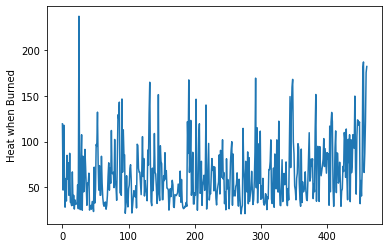

In [165]:
print(n_label_list)
plt.plot(heat_list)
plt.ylabel('Heat when Burned')
plt.show()

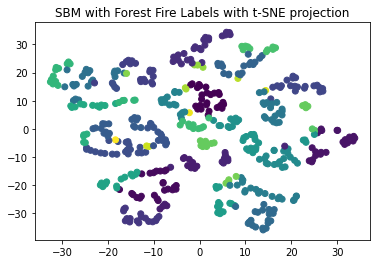

In [166]:
plt.figure()
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=n_label_list);
plt.title("SBM with Forest Fire Labels with t-SNE projection")
plt.show();

In [ ]:
test = np.zeros(500)
test[247] = 1
test[4] = 2
test[27] = 3
test[36] = 4
plt.figure()
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=test, alpha=0.5);
plt.title("SBM with Forest Fire Labels")
plt.show();